In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from networkx.algorithms.community import modularity

In [ ]:
# ================================
# Spectral Clustering Function
# ================================
def spectral_clustering_dense(graph, k, sigma=1.0, laplacian_type="normalized"):
    """
    Spectral Clustering using Full Eigen Decomposition for small graphs.
    
    Parameters:
    - graph: NetworkX graph
    - k: Number of clusters
    - sigma: Gaussian kernel parameter (controls neighborhood similarity)
    - laplacian_type: "unnormalized" or "normalized" (default: "normalized")

    Returns:
    - cluster_labels: Cluster assignments for each node
    """
    # Step 1: Compute the adjacency matrix (A)
    A = nx.to_numpy_array(graph)

    # Step 2: Compute similarity matrix (W) using Gaussian Kernel
    pairwise_dists = squareform(pdist(A, metric="euclidean"))  # Compute pairwise distances
    W = np.exp(-pairwise_dists ** 2 / (2.0 * sigma ** 2))  # Apply Gaussian kernel

    # Step 3: Compute the graph Laplacian
    D = np.diag(W.sum(axis=1))  # Degree matrix
    if laplacian_type == "normalized":
        D_inv_sqrt = np.diag(1.0 / np.sqrt(D.diagonal()))
        L = D_inv_sqrt @ W @ D_inv_sqrt  # Normalized Laplacian
    else:
        L = D - W  # Unnormalized Laplacian

    # Step 4: Compute the top k eigenvectors using full decomposition
    eigvals, eigvecs = np.linalg.eigh(L)  # Full decomposition

    # Step 5: Normalize row-wise (handling NaN values)
    X_norm = np.linalg.norm(eigvecs[:, -k:], axis=1, keepdims=True)
    X_norm[X_norm == 0] = 1  # Avoid division by zero
    X = eigvecs[:, -k:] / X_norm  # Normalize rows

    # Step 6: Apply K-means clustering on the transformed space
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)

    return cluster_labels

# ================================
# Clustering Evaluation Function
# ================================
def evaluate_clustering(graph, labels, ground_truth):
    """
    Evaluates clustering using Normalized Mutual Information (NMI) and Modularity Score.
    
    Parameters:
    - graph: NetworkX graph
    - labels: Cluster assignments from Spectral Clustering
    - ground_truth: Ground-truth community labels

    Returns:
    - NMI Score
    - Modularity Score
    """
    # Compute NMI Score
    nmi_score = normalized_mutual_info_score(ground_truth, labels)
    
    # Compute Modularity Score
    communities = {i: [] for i in set(labels)}
    for node, cluster in enumerate(labels):
        communities[cluster].append(node)
    modularity_score = modularity(graph, list(communities.values()))
    
    return nmi_score, modularity_score


# ================================
# Dataset Loading and Ground-Truth Extraction
# ================================
def load_dataset(path, label_attr=None):
    """
    Loads a GML dataset and extracts ground-truth labels from a given attribute.

    Parameters:
    - path: Path to GML file
    - label_attr: Attribute containing ground-truth labels

    Returns:
    - G: Processed undirected graph
    - ground_truth: Ground-truth labels (if available), else None
    """
    G_raw = nx.read_gml(path, label='label' if 'football' in path else None)
    G = G_raw.to_undirected()

    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    mapping = {node: idx for idx, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)

    ground_truth = None
    if label_attr:
        raw_labels = nx.get_node_attributes(G_raw, label_attr)
        if raw_labels:
            ground_truth = [raw_labels[node] for node in mapping.keys()]
            if isinstance(ground_truth[0], str):
                unique_labels = list(set(ground_truth))
                label_map = {label: i for i, label in enumerate(unique_labels)}
                ground_truth = [label_map[label] for label in ground_truth]
    return G, ground_truth

# ================================
# Generic Experiment Runner
# ================================
def run_spectral_experiments(graph, ground_truth, dataset_name, sigmas, ks):
    """
    Runs spectral clustering on a graph with multiple σ and k settings.

    Parameters:
    - graph: NetworkX graph
    - ground_truth: List of labels or None
    - dataset_name: String identifier
    - sigmas: List of sigma values
    - ks: List of k values

    Returns:
    - DataFrame of results
    """
    results = []

    for sigma in sigmas:
        for k in ks:
            try:
                labels = spectral_clustering_dense(graph, k=k, sigma=sigma, laplacian_type="normalized")
                nmi, mod = evaluate_clustering(graph, labels, ground_truth)

                results.append({
                    'dataset': dataset_name,
                    'sigma': sigma,
                    'k': k,
                    'NMI': nmi,
                    'Modularity': mod
                })

            except Exception as e:
                print(f"Error with sigma={sigma}, k={k}: {e}")

    df_results = pd.DataFrame(results)
    return df_results

# ================================
# Visualization Functions
# ================================

def plot_metric_vs_param(df, metric, param, title, xlabel):
    """
    Plot metric (NMI or Modularity) versus parameter (sigma or k) grouped by other param.
    """
    plt.figure(figsize=(10, 6))
    
    group_var = 'sigma'
    
    sns.lineplot(data=df, x=param, y=metric, hue=group_var, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(metric)
    plt.legend(title=group_var)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def run_full_experiment(dataset_path, label_attr, dataset_name):
    """
    Runs the full pipeline for spectral clustering experiments on a given dataset.
    
    Parameters:
    - dataset_path: string, path to the dataset file
    - label_attr: string, name of the attribute to be used as ground truth labels
    - dataset_name: string, name of the dataset (for display and plotting purposes)
    
    Returns:
    - df_results: DataFrame containing results from spectral clustering experiments
    """
    print(f"Loading dataset {dataset_name}...")
    G, ground_truth = load_dataset(dataset_path, label_attr)
    print(f"Running spectral clustering experiments on {dataset_name}...")
    
    sigmas = [0.1, 0.5, 1.0, 2.0, 5.0]
    ks = [2, 4, 6, 8, 10, 12, 16]
    
    df_results = run_spectral_experiments(G, ground_truth, dataset_name, sigmas, ks)
    
    print("Unique k values in results:")
    print(sorted(df_results['k'].unique()))

    # Plot NMI vs sigma for different k
    plot_metric_vs_param(df_results, metric='NMI', param='k',
                         title=f'NMI vs Number of Clusters k for Different Sigma ({dataset_name})',
                         xlabel='Sigma')
    
    # Plot Modularity vs k for different sigma
    plot_metric_vs_param(df_results, metric='Modularity', param='k',
                         title=f'Modularity vs Number of Clusters k for Different Sigma ({dataset_name})',
                         xlabel='Number of Clusters k')

    return df_results

Loading dataset Books...
Running spectral clustering experiments on Books...
Unique k values in results:
[np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(10), np.int64(12), np.int64(16)]


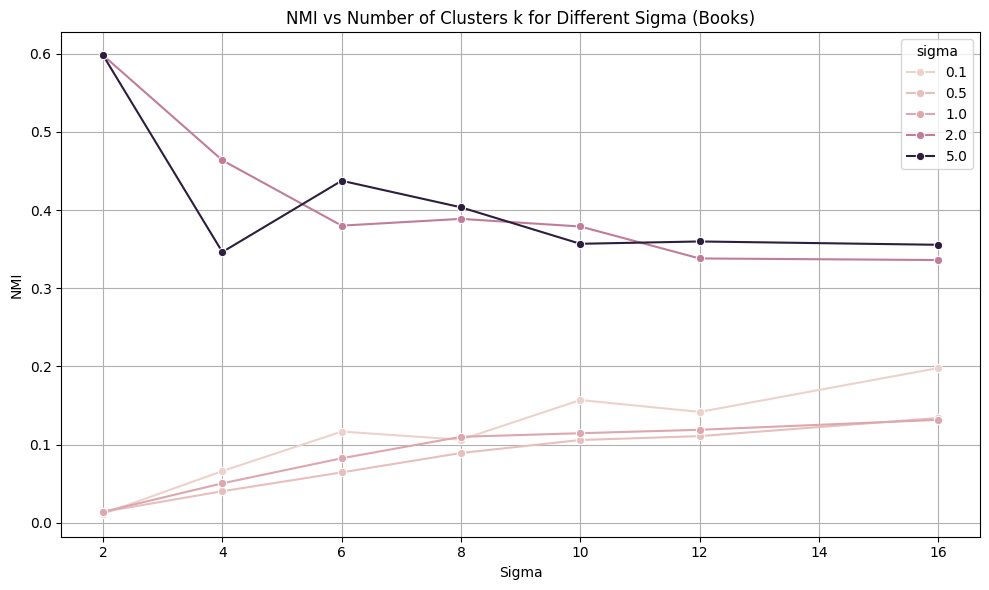

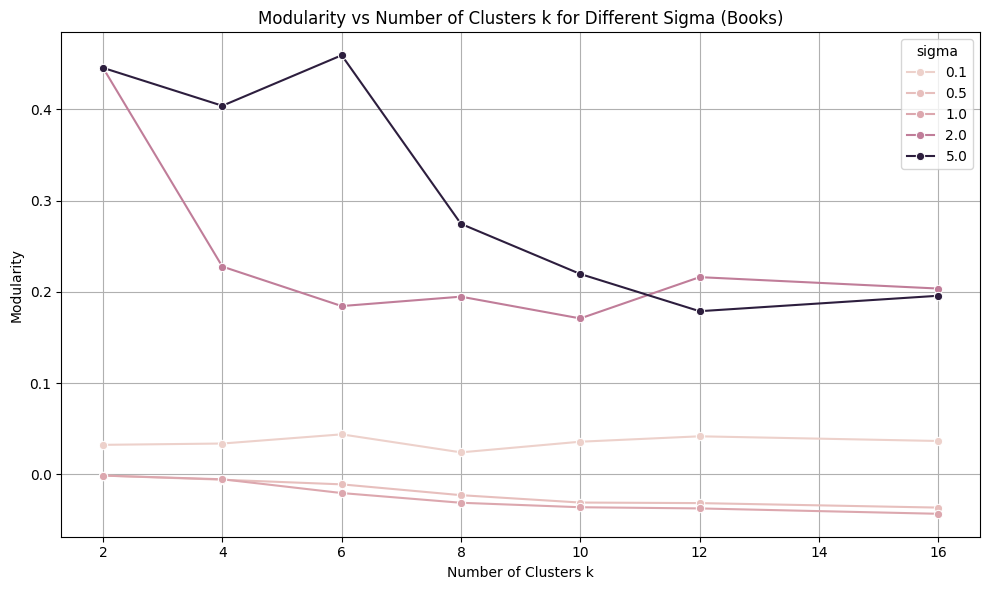

In [41]:
#df_polbooks = run_full_experiment("./data/football.gml", label_attr='value', dataset_name="Football")
df_football = run_full_experiment("./data/polbooks.gml", label_attr='value', dataset_name="Books")
